In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

### Helpers for using DBSCAN to create clusters and viewing them

In [212]:
# Uses DBSCAN to assign labels of a particular type and property to clusters
def DBSCAN_label_subset(filename, eps, min_samples, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
    # dbscan expects multiple dimensions
    df["zeros"]=0
    
    # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values_w_0s = df.loc[:, ["node2", "zeros"]]
    values = values_w_0s.loc[:,"node2"]
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(values_w_0s)

    return (db, values)


# Chooses values for the epsilon and min_samples parameters of DBSCAN to be used for
# clustering labels of a given type and property.
def choose_DBSCAN_params(filename, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
    # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values = np.array(df.loc[:,"node2"]).reshape(-1, 1)
    
    # min_samples would ideally be set with some domain-insight.
    # To make this automated, we'll use a heuristic - ln(number of data points)
    min_samples = int(np.floor(np.log(len(values))))
    min_samples = max(min_samples, 1) # don't choose a number less than 1
    print("Choosing min_samples = floor(ln(# data points)) = {}".format(min_samples))
    
    # epsilon can be chosen by plotting the distances of the k'th nearest neighbor from each point
    # where k is min_samples. Points that belong to clusters should have smaller distances, whereas
    # noise points can have distances that are much farther. We'll look for a knee in this graph to set epsilon.
    print("Computing distances to k'th nearest neighbor for each point where k = min_samples...")
    
    neigh = NearestNeighbors(n_neighbors = min_samples + 1) # +1 so we find k'th nearest neighbor not including the point iteslf.
    values_neigh = neigh.fit(values)
    distances, indices = values_neigh.kneighbors(values)
    distances = np.sort(distances[:,min_samples], axis = 0)
    
    kneedle = KneeLocator(range(len(distances)), distances, S=1, curve='convex', direction='increasing', interp_method = 'polynomial')
    kneedle.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print("knee found at distance {}".format(kneedle.knee_y))
    epsilon = kneedle.knee_y
    
    return (min_samples, epsilon)


# Given values that have been assigned to clusters,
# return a list of intervals that are consistent with these clusters
def infer_intervals_from_clusters(values, labels):
    
    values = np.array(values)
    labels = np.array(labels)
    
    # sort values and corresponding labels in ascending order
    labels = np.array([l for l, v in sorted(zip(labels, values), key=lambda pair: pair[1])])
    values.sort()
    
    intervals = [(None, None)] # initially a single interval with no lower or upper bound
    
    cur_label = labels[0]
    for i in range(len(labels)):
        # if new label, set upper bound of previous interval,
        # and start lower bound of a new interval.
        if labels[i] != cur_label:
            prev_interval_lb = (intervals[-1])[0]
            new_interval_edge = values[i-1] + ((values[i] - values[i-1]) / 2)
            intervals[-1] = (prev_interval_lb, new_interval_edge)
            intervals.append((new_interval_edge, None))
            cur_label = labels[i]
    
    return intervals
    

def fixed_width_partition(filename, width, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
   # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values = df.loc[:,"node2"]
    labels = values - (values % width)
    
    return (labels, values)
    

def view_clustering(labels, values, min_hist_bin = None, max_hist_bin = None, bin_size = None):
    if min_hist_bin is None:
        min_hist_bin = values.min() - 1
    if max_hist_bin is None:
        max_hist_bin = values.max() + 1
    if bin_size is None:
        bin_size = (max_hist_bin - min_hist_bin) / 10 # default 10 bins

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)


    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    ax = plt.gca()
    ax.set_facecolor("xkcd:silver")

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = values.loc[class_member_mask]
        plt.hist(xy, color=tuple(col), bins = np.arange(min_hist_bin, max_hist_bin, bin_size), histtype = 'step')

    plt.xlabel("value")
    plt.ylabel("count")
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

File paths for passing in python

In [5]:
path = "/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/"
year_file = "{}Q44.entity_attribute_labels_time.year.tsv".format(path)
quantity_file = "{}Q44.entity_attribute_labels_quantity.tsv".format(path)

File paths for using in kgtk commands

In [6]:
work_dir = "/Users/nicklein/Documents/grad_school/Research/data"

In [7]:
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(work_dir)
os.environ['DATA'] = "{}/Q44".format(work_dir)
os.environ['NAME'] = "Q44"
os.environ["OUT"] = "{}/Q44_profiler_output".format(work_dir)

## Exploring ways to discretize labels
We'll start by looking at year values as an example

Taking a look at most prevalent type, property pairs within year-valued labels

In [176]:
!head -5 $OUT/$NAME.entity_attribute_labels_time.year.tsv | column -t -s $'\t'

entity  node1     label  node2  type_label            property_label  id
Q1011   Q112099   P571   1975   'island nation'@en    'inception'@en  E1
Q1011   Q3624078  P571   1975   'sovereign state'@en  'inception'@en  E2
Q1019   Q112099   P571   1960   'island nation'@en    'inception'@en  E3
Q1019   Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E4


In [180]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val)' \
--return 'distinct type as type, p as prop, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type      prop  count  type_label            property_label
Q3624078  P571  88     'sovereign state'@en  'inception'@en
Q4830453  P571  50     'business'@en         'inception'@en
Q131734   P571  45     'brewery'@en          'inception'@en
Q6256     P571  31     'country'@en          'inception'@en
Q6881511  P571  24     'enterprise'@en       'inception'@en


Let's look at year values for type = **business** prop = **inception**

First let's see what triples match these labels...

In [104]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv -i $DATA/$NAME.label.en.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), label: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q4830453" AND p = "P571" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type      prop  year  entity_label                    type_label     property_label
Q562552    Q4830453  P571  1333  'Oettinger Brewery'@en          'business'@en  'inception'@en
Q153075    Q4830453  P571  1615  'Grolsch Brewery'@en            'business'@en  'inception'@en
Q1397604   Q4830453  P571  1664  'Kronenbourg Brewery'@en        'business'@en  'inception'@en
Q12002324  Q4830453  P571  1698  'Shepherd Neame Brewery'@en     'business'@en  'inception'@en
Q1164954   Q4830453  P571  1769  'Dubuisson Brewery'@en          'business'@en  'inception'@en
Q609966    Q4830453  P571  1795  'Budweiser Bier Bürgerbräu'@en  'business'@en  'inception'@en
Q2601227   Q4830453  P571  1819  'Sinebrychoff'@en               'business'@en  'inception'@en
Q3640368   Q4830453  P571  1846  'Peroni'@en                     'business'@en  'inception'@en
Q865859    Q4830453  P571  1846  'Peroni Brewery'@en             'business'@en  'inception'@en
Q113215    Q4830453  P571  1847  'Carlsberg Group'

### Testing out DBSCAN with varying values for parameters epsilon and min_samples
epsilon: distance away from a point that we consider "in the neighborhood" of that point

min_samples: minimum number of points within a point's neighborhood (including the point itself) for us to consider these points as a core point

core points and points within their neighborhoods form clusters

**eps = 5, min_samples = 1**

Note that with min_samples = 1, all points will belong to a cluster since a single point can constitute its own cluster.

Estimated number of clusters: 20
Estimated number of noise points: 0


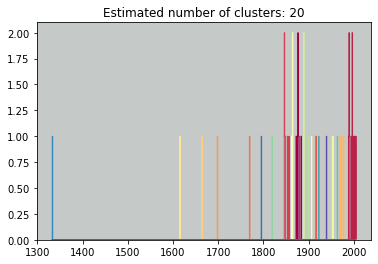

In [45]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 1)
view_clustering(db_bus_incep.labels_, values_bus_incep, bin_size = 1)

zooming in...

Estimated number of clusters: 20
Estimated number of noise points: 0


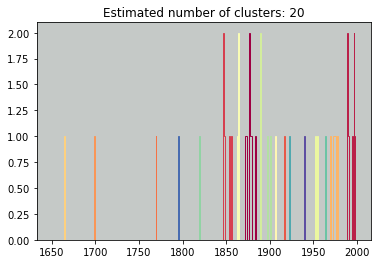

In [46]:
view_clustering(db_bus_incep.labels_, values_bus_incep, 1650, 2000, 1)

**eps = 10, min_samples = 1**

Estimated number of clusters: 11
Estimated number of noise points: 0


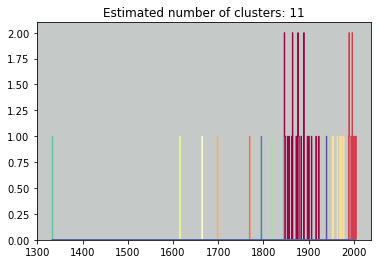

In [47]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 10, min_samples = 1)
view_clustering(db_bus_incep.labels_, values_bus_incep, bin_size = 1)

zooming in...

Estimated number of clusters: 11
Estimated number of noise points: 0


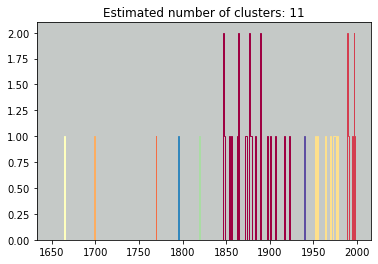

In [48]:
view_clustering(db_bus_incep.labels_, values_bus_incep, 1650, 2000, 1)

**eps = 5, min_samples = 10**

Note that since min_samples is now > 1, there will be some noise points - points that aren't assigned to a cluster.

Estimated number of clusters: 8
Estimated number of noise points: 12


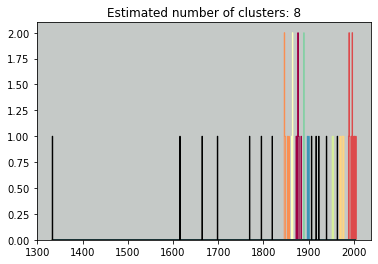

In [49]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 2)
view_clustering(db_bus_incep.labels_, values_bus_incep, bin_size = 1)

zooming in...

Estimated number of clusters: 8
Estimated number of noise points: 12


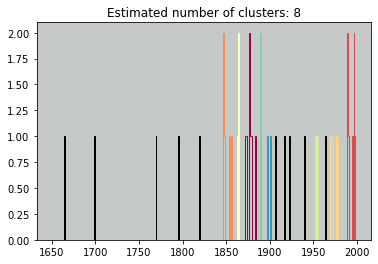

In [50]:
view_clustering(db_bus_incep.labels_, values_bus_incep, 1650, 2000, 1)

### If instead of DBSCAN we just use a fixed width of 5 years...

In [31]:
labels_bus_incep, values_bus_incep = fixed_width_partition(year_file, width = 5, l_type = "Q4830453", l_prop = "P571")

Estimated number of clusters: 31
Estimated number of noise points: 0


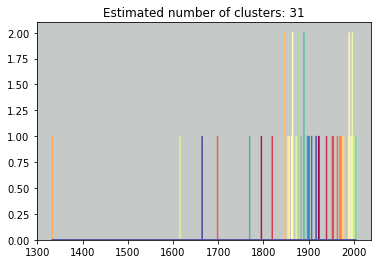

In [51]:
view_clustering(labels_bus_incep, values_bus_incep, bin_size = 1)

zooming in...

Estimated number of clusters: 31
Estimated number of noise points: 0


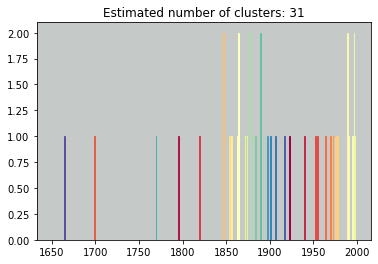

In [52]:
view_clustering(labels_bus_incep, values_bus_incep, 1650, 2000, 1)

### Now using an automated approach to set DBSCAN parameters

min_samples is chosen using a heuristic that is a function of number of data points

epsilon will then be chosen based on the value for min_samples that was chosen. The distance you have to go from a given point to find min_samples number of points will be small and fairly similar for points that are in a more densley packed area, and larger for points in a more sparsely packed area. We want to set epsilon to some distance that will put the dense areas into clusters. To do this, we can plot the distances of the min_samples'th nearest neighbor from each point in increasing order of distance. If we look at where distance most sharply increases, this should correspond to the border between the distance for a point in a dense area and the distance for a point in a more sparse area. We'll choose this distance for epsilon.

Choosing min_samples = floor(ln(# data points)) = 3
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 27.0


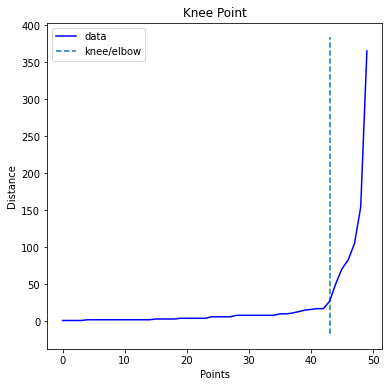

In [213]:
min_samples, epsilon = choose_DBSCAN_params(year_file, l_type = "Q4830453", l_prop = "P571")

Estimated number of clusters: 1
Estimated number of noise points: 4


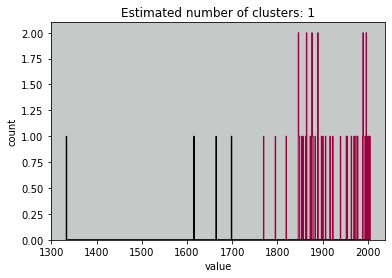

In [214]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = epsilon, min_samples = min_samples)
view_clustering(db_bus_incep.labels_, values_bus_incep, bin_size = 1)

### We want explicit intervals, not just an assignment of the points we have to clusters.
We can find intervals that are compatible with the clustering we have. Here is the result for the above clustering:

In [180]:
intervals = infer_intervals_from_clusters(values_bus_incep, db_bus_incep.labels_)
print(intervals)

[(None, 1733.5), (1733.5, None)]


### Next let's look at what the clustering looks like for another type that has more data samples
We'll look at quantities now

Taking a look at most prevalent type, property pairs within quantity-valued labels

*The formatting here is a little confusing - when si_units or wd_units are blank, columns to the right of them will left align and not fall under the right header*

In [149]:
!head -5 $OUT/$NAME.entity_attribute_labels_quantity.tsv | column -t -s $'\t'

entity    node1    label  node2  si_units            wd_units                      type_label  property_label  id
Q1000597  Q3957    P1082  75074  'town'@en           'population'@en               E1
Q1011     Q112099  P1081  0.57   'island nation'@en  'Human Development Index'@en  E2
Q1011     Q112099  P1081  0.572  'island nation'@en  'Human Development Index'@en  E3
Q1011     Q112099  P1081  0.575  'island nation'@en  'Human Development Index'@en  E4


In [38]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_quantity.tsv \
--graph-cache $STORE \
--match 'quantity: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct type as type, p as prop, si as si_units, wd as wd_units, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type      prop   si_units  wd_units              count                         type_label                   property_label
Q3624078  P1082  3242      'sovereign state'@en  'population'@en
Q3624078  P2131  Q4917     3081                  'sovereign state'@en          'nominal GDP'@en
Q3624078  P2132  Q4917     2953                  'sovereign state'@en          'nominal GDP per capita'@en
Q3624078  P2134  Q4917     2823                  'sovereign state'@en          'total reserves'@en
Q3624078  P1081  2175      'sovereign state'@en  'Human Development Index'@en


Let's look at values for type = **sovereign state** prop = **population**

Choosing min_samples = floor(ln(# data points)) = 8
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 436200.0


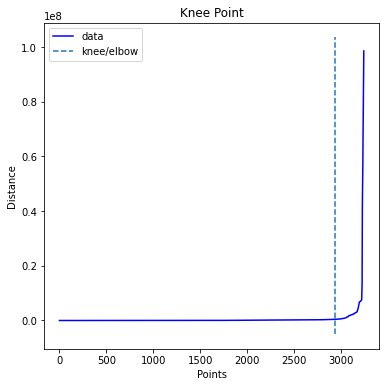

In [209]:
min_samples, epsilon = choose_DBSCAN_params(quantity_file, l_type = "Q3624078", l_prop = "P1082")

Estimated number of clusters: 9
Estimated number of noise points: 229


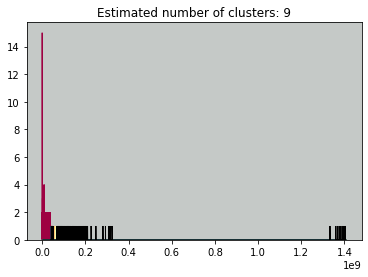

In [182]:
db, values = DBSCAN_label_subset(quantity_file, l_type = "Q3624078", l_prop = "P1082", eps = epsilon, min_samples = min_samples)
view_clustering(db.labels_, values, bin_size = 1000)

zooming in...

Estimated number of clusters: 9
Estimated number of noise points: 229


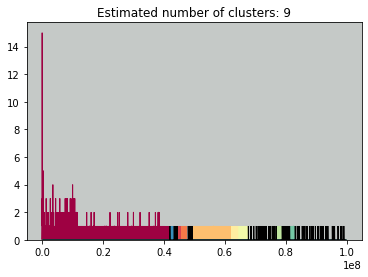

In [186]:
view_clustering(db.labels_, values, max_hist_bin = .1e9, bin_size = 1000)

In [187]:
intervals = infer_intervals_from_clusters(values, db.labels_)
print(intervals)

[(None, 41699675.5), (41699675.5, 42070375.0), (42070375.0, 43152169.5), (43152169.5, 44616481.0), (44616481.0, 45753553.0), (45753553.0, 47679648.0), (47679648.0, 49304297.5), (49304297.5, 62309824.5), (62309824.5, 64595629.5), (64595629.5, 67584245.5), (67584245.5, 77075314.5), (77075314.5, 78851500.0), (78851500.0, 81415700.0), (81415700.0, 83064200.0), (83064200.0, None)]


Let's also try with values for type = **sovereign state** prop = **nominal GDP**

Choosing min_samples = floor(ln(# data points)) = 8
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 17904944666.281006


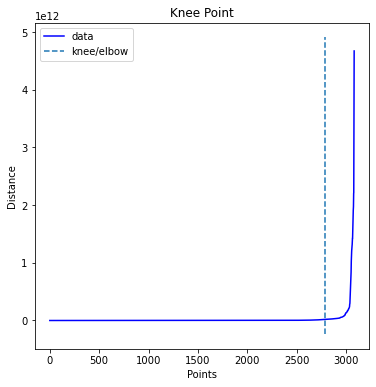

In [210]:
min_samples, epsilon = choose_DBSCAN_params(quantity_file, l_type = "Q3624078", l_prop = "P2131")

Estimated number of clusters: 11
Estimated number of noise points: 210


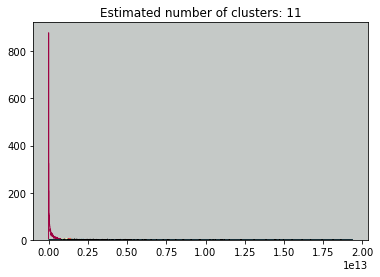

In [189]:
db, values = DBSCAN_label_subset(quantity_file, l_type = "Q3624078", l_prop = "P2131", eps = epsilon, min_samples = min_samples)
view_clustering(db.labels_, values, bin_size = 1e10)

zooming in...

Estimated number of clusters: 11
Estimated number of noise points: 210


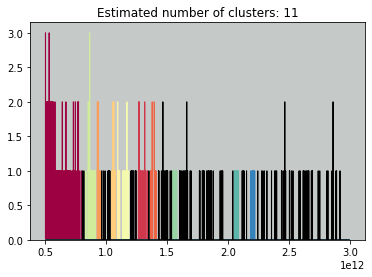

In [191]:
view_clustering(db.labels_, values, min_hist_bin = .05e13, max_hist_bin = .3e13, bin_size = 1e9)

In [192]:
intervals = infer_intervals_from_clusters(values, db.labels_)
print(intervals)

[(None, 800249412297.1975), (800249412297.1975, 823761840597.015), (823761840597.015, 917860400072.625), (917860400072.625, 956091683115.263), (956091683115.263, 1035671933673.0149), (1035671933673.0149, 1085040714447.8601), (1085040714447.8601, 1122253520111.71), (1122253520111.71, 1199439960689.01), (1199439960689.01, 1245943385630.9502), (1245943385630.9502, 1344214874159.335), (1344214874159.335, 1355444118001.38), (1355444118001.38, 1418665295631.825), (1418665295631.825, 1539589374763.045), (1539589374763.045, 1589309451086.46), (1589309451086.46, 2045028417050.3), (2045028417050.3, 2100846744102.31), (2100846744102.31, 2168446525813.74), (2168446525813.74, 2230957447379.3203), (2230957447379.3203, None)]


Let's also try with values for type = **sovereign state** prop = **Human Development Index**

Choosing min_samples = floor(ln(# data points)) = 7
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 0.0020000000000000018


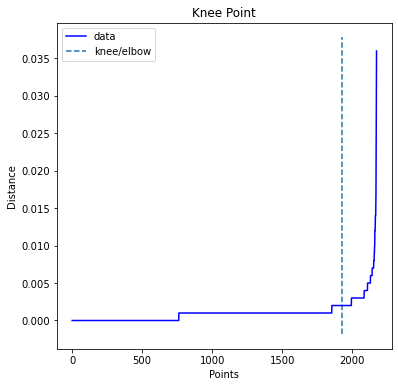

In [211]:
min_samples, epsilon = choose_DBSCAN_params(quantity_file, l_type = "Q3624078", l_prop = "P1081")

Estimated number of clusters: 14
Estimated number of noise points: 93


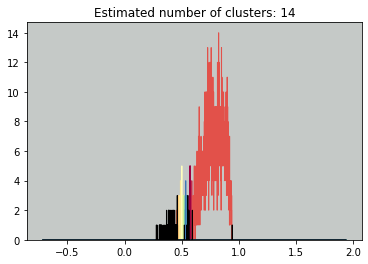

In [197]:
db, values = DBSCAN_label_subset(quantity_file, l_type = "Q3624078", l_prop = "P1081", eps = epsilon, min_samples = min_samples)
view_clustering(db.labels_, values, bin_size = 1e-3)

zooming in...

Estimated number of clusters: 14
Estimated number of noise points: 93


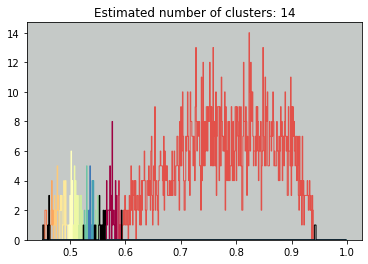

In [204]:
view_clustering(db.labels_, values, min_hist_bin = .45, max_hist_bin = 1, bin_size = 1e-3)

In [205]:
intervals = infer_intervals_from_clusters(values, db.labels_)
print(intervals)

[(None, 0.45349999999999996), (0.45349999999999996, 0.4595), (0.4595, 0.4645), (0.4645, 0.47050000000000003), (0.47050000000000003, 0.4815), (0.4815, 0.497), (0.497, 0.506), (0.506, 0.5165), (0.5165, 0.5235000000000001), (0.5235000000000001, 0.5255000000000001), (0.5255000000000001, 0.534), (0.534, 0.538), (0.538, 0.544), (0.544, 0.5465), (0.5465, 0.5515), (0.5515, 0.565), (0.565, 0.5865), (0.5865, 0.593), (0.593, 0.595), (0.595, 0.9405000000000001), (0.9405000000000001, None)]
